# LLM

### Openai

In [38]:
import os
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

llm_openai = ChatOpenAI(
                api_key=OPENAI_API_KEY, 
                model='gpt-3.5-turbo', 
                temperature=0.7)
llm_openai

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000022808585A00>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x00000228085853A0>, root_client=<openai.OpenAI object at 0x00000228085859A0>, root_async_client=<openai.AsyncOpenAI object at 0x0000022808585FD0>, temperature=0.7, model_kwargs={}, openai_api_key=SecretStr('**********'))

In [39]:
# verify
llm_openai.invoke('what is the capital of Japan?')

AIMessage(content='The capital of Japan is Tokyo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 14, 'total_tokens': 21, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bvb9LNR9j3b0Q8VS6estGbqo6Tde8', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--6000e375-264d-44db-9075-89b381275205-0', usage_metadata={'input_tokens': 14, 'output_tokens': 7, 'total_tokens': 21, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [40]:
# verify
from langchain_core.messages import HumanMessage, SystemMessage

sample_messages = [
    SystemMessage(content="You are a pet veterinarian."),
    HumanMessage(content="Explain cat hissing sound")
]
sample_answer = llm_openai.invoke(sample_messages)
sample_answer.content

"When a cat hisses, it is a sign of fear, stress, or aggression. Cats hiss as a warning signal to communicate that they are feeling threatened or uncomfortable. It is their way of telling you or another animal to back off and give them space.\n\nHissing is often accompanied by other body language cues such as flattened ears, dilated pupils, raised fur, and a crouched or tense body posture. It is essential to respect a hissing cat's boundaries and avoid further provoking them.\n\nIf your cat is hissing frequently or in response to certain triggers, it is crucial to assess the situation and try to identify the cause of their distress. If the hissing behavior persists and you are concerned about your cat's well-being, it is recommended to consult with a veterinarian or a professional animal behaviorist for further guidance."

### Deepinfra gemma

In [57]:
from langchain_community.chat_models import ChatDeepInfra

llm_deepinfra = ChatDeepInfra(
                    model="google/gemma-3-4b-it",
                    temperature=0.7,
                    max_tokens=512,
                )
llm_deepinfra

ChatDeepInfra(model_name='google/gemma-3-4b-it', deepinfra_api_token='Aqaz1fN9vn5oWeqdAp6BZg04vTf2Iv8V', temperature=0.7, model_kwargs={}, max_tokens=512)

In [42]:
# Verify
sample_answer = llm_deepinfra.invoke("what is the capital of Japan?")
sample_answer.content

'The capital of Japan is **Tokyo**. \n\nIt’s a massive, vibrant city and the center of Japanese government, culture, and economy. 😊'

In [82]:
# Verify 2
sample_messages = [
    SystemMessage(content="You are a travel expert."),
    HumanMessage(content="what is the capital of Japan?")
]
sample_answer = llm_deepinfra.invoke(sample_messages)
sample_answer.content

'Ah, a classic question! The capital of Japan is **Tokyo** (officially Tokyo-to). \n\nIt’s a truly fascinating city – a massive blend of ancient tradition and cutting-edge modernity. \n\nWould you like to know anything more about Tokyo, like:\n\n*   Its history?\n*   Popular attractions (like the Shibuya crossing or the Imperial Palace)?\n*   What it’s like to experience it?'

# Graph Builder

In [ ]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [ ]:
class State(TypedDict): #inherit Typedict 
   # `add_messages` is a reducer: it appends new messages to the existing list
    messages: Annotated[list, add_messages] 

# example:
# {
#     "messages": [
#         {"role": "user",    "content": "hi"},
#         {"role": "assistant", "content": "Hello!"},
#         ...
#     ]
# }

In [ ]:
# chatbot node
def chatbot(state: State) -> State: 
    reply = llm_deepinfra.invoke(state["messages"])
    return {"messages": reply}         

In [90]:
graph_builder = StateGraph(State)

# node
graph_builder.add_node('llm_chatbot',chatbot)
# add start edge
graph_builder.add_edge(START, 'llm_chatbot')
# add end edge
graph_builder.add_edge('llm_chatbot', END)


# compile the graph
graph = graph_builder.compile()

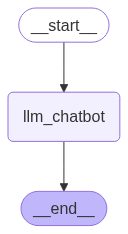

In [97]:
# Visualize
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [92]:
response = graph.invoke({"messages": 'hi'})
response

{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='9778770f-fea4-4948-b3c6-8b28ddc905be'),
  AIMessage(content="Hi there! How's your day going so far? 😊 \n\nIs there anything you'd like to chat about, or were you just saying hello?", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 10, 'total_tokens': 44, 'completion_tokens': 34, 'estimated_cost': 1.5599999999999999e-06}, 'model': 'google/gemma-3-4b-it', 'finish_reason': 'stop'}, id='run--1783a3c9-6752-4298-a781-e562ec395765-0')]}

In [104]:
# response['messages']
response['messages'][-1].content

'As an AI, I don’t actually *know* your name! You haven’t told me. 😊 \n\nYou can tell me if you’d like – I’m happy to remember it!'